Training LSTM: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


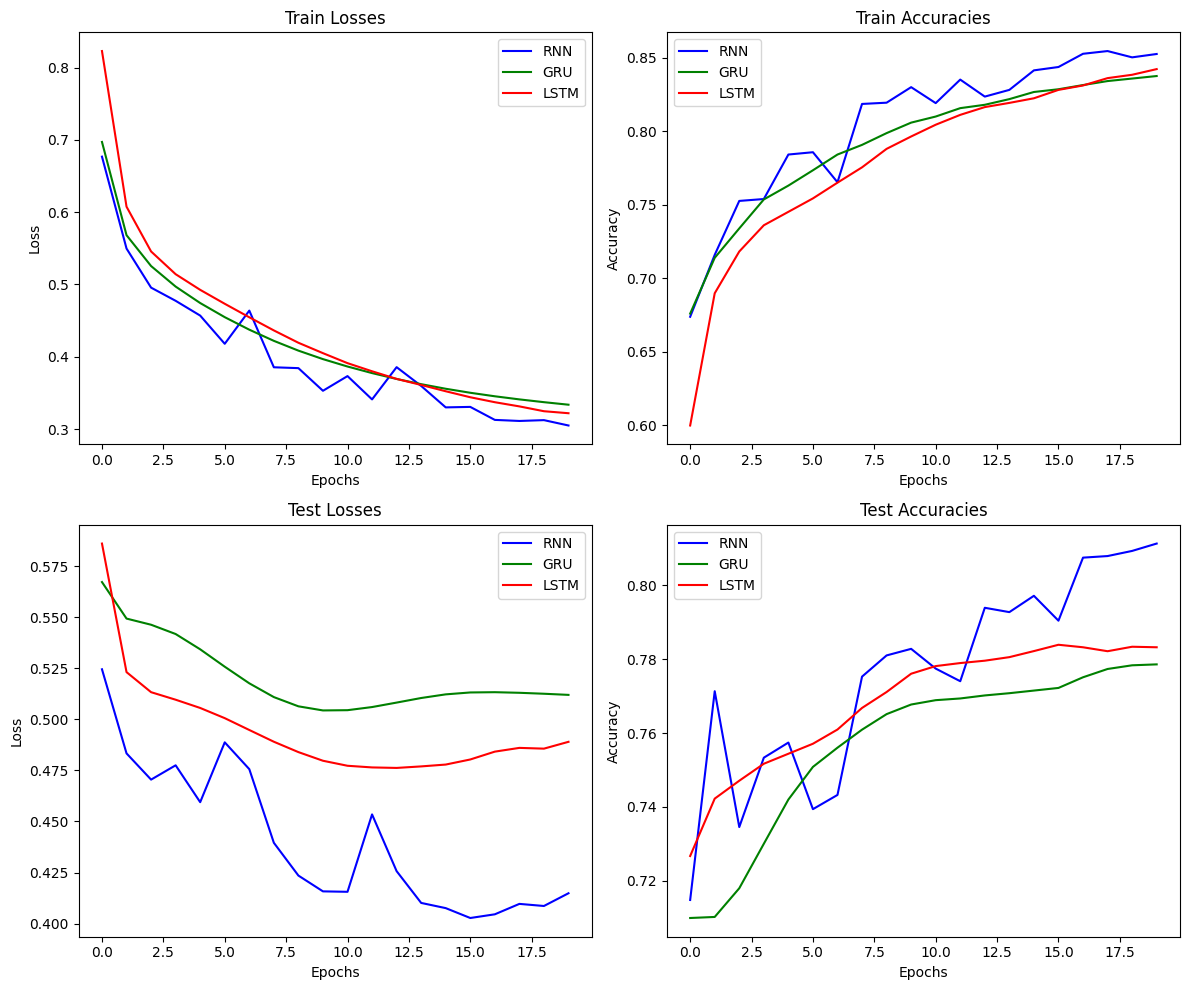


Model Comparison:
Model      Train Loss   Test Loss    Train Acc    Test Acc    
--------------------------------------------------
RNN        0.3050       0.4149       0.8525       0.8114      
GRU        0.3337       0.5119       0.8375       0.7786      
LSTM       0.3220       0.4890       0.8422       0.7833      

Best model based on test accuracy: RNN (0.8114)


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from ucimlrepo import fetch_ucirepo
from IPython.display import clear_output
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

NUM_CLASSES = 3
HIDDEN_SIZE = 32
NUM_EPOCHS = 20
BATCH_SIZE = 64
TEST_SIZE = 0.8
SEQUENCE_LENGTH = 5
LEARNING_RATE = 0.01
MOMENTUM = 0.9


def load_and_preprocess_data():
    steel_industry_energy_consumption = fetch_ucirepo(id=851)

    X = steel_industry_energy_consumption.data.features
    y = steel_industry_energy_consumption.data.targets
    categorical_columns = X.select_dtypes(include='object').columns
    numerical_columns = X.select_dtypes(include=np.number).columns

    y = LabelEncoder().fit_transform(np.ravel(y))

    columnTransformer = ColumnTransformer(
        transformers=[
            ('categorical', TargetEncoder(), categorical_columns),
            ('num', StandardScaler(), numerical_columns)]
    )
    X = columnTransformer.fit_transform(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, shuffle=False)

    return X_train, X_test, y_train, y_test


class EnergyConsumptionDataset(Dataset):

    def __init__(self, X, y, seq_length=1):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y).long()
        self.seq_length = seq_length

    def __len__(self):
        return self.X.shape[0] - (self.seq_length - 1)

    def __getitem__(self, index):
        return (self.X[index:index + self.seq_length],
                self.y[index + self.seq_length - 1])


def create_data_loaders(X_train, X_test, y_train, y_test, batch_size, seq_length):

    train_loader = DataLoader(
        EnergyConsumptionDataset(X_train, y_train, seq_length),
        batch_size=batch_size,
        shuffle=False
    )

    test_loader = DataLoader(
        EnergyConsumptionDataset(X_test, y_test, seq_length),
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, test_loader


def plot_loss_acc(train_losses, test_losses, train_accuracies, test_accuracies):

    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


class RNNClassifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.RNN(
            input_size=in_features,
            hidden_size=hidden_size,
            batch_first=True,
            nonlinearity='relu'
        )
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, out = self.encoder(x)
        return self.classifier(out[-1])


class LSTMClassifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.LSTM(
            input_size=in_features,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (hn, _) = self.encoder(x)
        return self.classifier(hn[-1])


class GRUClassifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.GRU(
            input_size=in_features,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, out = self.encoder(x)
        return self.classifier(out[-1])


def train_model(model, train_loader, test_loader, model_name, num_epochs=NUM_EPOCHS):
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in tqdm(range(1, num_epochs + 1), desc=f"Training {model_name}"):
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.shape[0]
            train_accuracy += (predictions.argmax(axis=1) == y_batch).sum().item()

        model.eval()
        test_loss, test_accuracy = 0.0, 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                test_loss += loss.item() * X_batch.shape[0]
                test_accuracy += (predictions.argmax(axis=1) == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        test_loss /= len(test_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        test_accuracy /= len(test_loader.dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }


def plot_comparison(results):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(results['RNN']['train_losses'], label='RNN', color='blue')
    axes[0, 0].plot(results['GRU']['train_losses'], label='GRU', color='green')
    axes[0, 0].plot(results['LSTM']['train_losses'], label='LSTM', color='red')
    axes[0, 0].set_title('Train Losses')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(results['RNN']['train_accuracies'], label='RNN', color='blue')
    axes[0, 1].plot(results['GRU']['train_accuracies'], label='GRU', color='green')
    axes[0, 1].plot(results['LSTM']['train_accuracies'], label='LSTM', color='red')
    axes[0, 1].set_title('Train Accuracies')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    axes[1, 0].plot(results['RNN']['test_losses'], label='RNN', color='blue')
    axes[1, 0].plot(results['GRU']['test_losses'], label='GRU', color='green')
    axes[1, 0].plot(results['LSTM']['test_losses'], label='LSTM', color='red')
    axes[1, 0].set_title('Test Losses')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()

    axes[1, 1].plot(results['RNN']['test_accuracies'], label='RNN', color='blue')
    axes[1, 1].plot(results['GRU']['test_accuracies'], label='GRU', color='green')
    axes[1, 1].plot(results['LSTM']['test_accuracies'], label='LSTM', color='red')
    axes[1, 1].set_title('Test Accuracies')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


def print_comparison_table(results):
    print("\nModel Comparison:")
    print(f"{'Model':<10} {'Train Loss':<12} {'Test Loss':<12} {'Train Acc':<12} {'Test Acc':<12}")
    print("-" * 50)

    for model_name in ['RNN', 'GRU', 'LSTM']:
        metrics = results[model_name]
        print(f"{model_name:<10} "
              f"{metrics['train_losses'][-1]:<12.4f} "
              f"{metrics['test_losses'][-1]:<12.4f} "
              f"{metrics['train_accuracies'][-1]:<12.4f} "
              f"{metrics['test_accuracies'][-1]:<12.4f}")


def find_best_model(results):
    final_test_accuracies = {
        model_name: metrics['test_accuracies'][-1]
        for model_name, metrics in results.items()
    }

    best_model = max(final_test_accuracies, key=final_test_accuracies.get)
    print(f"\nBest model based on test accuracy: {best_model} "
          f"({final_test_accuracies[best_model]:.4f})")
    return best_model


def main():
    X_train, X_test, y_train, y_test = load_and_preprocess_data()

    train_loader, test_loader = create_data_loaders(
        X_train, X_test, y_train, y_test, BATCH_SIZE, SEQUENCE_LENGTH)

    input_size = X_train.shape[1]
    models = {
        'RNN': RNNClassifier(input_size, NUM_CLASSES, HIDDEN_SIZE),
        'GRU': GRUClassifier(input_size, NUM_CLASSES, HIDDEN_SIZE),
        'LSTM': LSTMClassifier(input_size, NUM_CLASSES, HIDDEN_SIZE)
    }

    results = {}
    for model_name, model in models.items():
        results[model_name] = train_model(model, train_loader, test_loader, model_name, NUM_EPOCHS)

    plot_comparison(results)

    print_comparison_table(results)

    find_best_model(results)


if __name__ == "__main__":
    main()

## Ручная реализация